In [52]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import decoupler

import os
import sys
import logging
import warnings
from deg import *

In [53]:
adata_female_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_98_80.h5ad'
adata_male_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_98_85.h5ad'
#adata_with_features_file = 
adata_female = sc.read_h5ad(adata_female_file)
adata_male = sc.read_h5ad(adata_male_file)

In [54]:
# subset to skeletal muscle stem cells
adata_musc_f = adata_female[adata_female.obs['C_scANVI'] == 'Skeleton MuSc']
adata_musc_m = adata_male[adata_male.obs['C_scANVI'] == 'Skeleton MuSc']

## Geneset (atrophy/senescence) scores

In [55]:
custom_atrophy_pathway = ["UBB","UBC","FBXO32","TRIM63","MDM2","FBXO30","CAMK2B","TIE1","PSMA1","PSMA2","PSMA3","PSMA4","PSMA5","PSMA6","PSMA7","PSMB1","PSMB2","PSMB3","PSMB4","FBXO21","FBXO31","NEDD4","UBE2B","UBE2G1","UBE2J1","CTSL","CTSV","BNIP3","DEPP1","GABARAPL1","MAP1LC3","RETREG1","SQSTM1","CAPN1","CAPN2","ATF4","FOXO1","FOXO3A","HDAC9","RUNX1","AMPD3","CHRNA1","CDKN1A"]
# Convert to mouse gene format
custom_atrophy_pathway_mouse = [gene.capitalize() for gene in custom_atrophy_pathway]
print(custom_atrophy_pathway_mouse)

['Ubb', 'Ubc', 'Fbxo32', 'Trim63', 'Mdm2', 'Fbxo30', 'Camk2b', 'Tie1', 'Psma1', 'Psma2', 'Psma3', 'Psma4', 'Psma5', 'Psma6', 'Psma7', 'Psmb1', 'Psmb2', 'Psmb3', 'Psmb4', 'Fbxo21', 'Fbxo31', 'Nedd4', 'Ube2b', 'Ube2g1', 'Ube2j1', 'Ctsl', 'Ctsv', 'Bnip3', 'Depp1', 'Gabarapl1', 'Map1lc3', 'Retreg1', 'Sqstm1', 'Capn1', 'Capn2', 'Atf4', 'Foxo1', 'Foxo3a', 'Hdac9', 'Runx1', 'Ampd3', 'Chrna1', 'Cdkn1a']


In [56]:
sensig_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SenSig_DEGs.csv'
fridman_down_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_down_orthologs.csv'
fridman_up_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_up_orthologs.csv'
senmayo_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SAUL_SEN_MAYO_UP_IN_SEN.v2024.1.Mm.gmt'
cell_age_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/cellAge_orthologs.csv'
cell_age_human_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/cellAge/cellage3.tsv'

In [57]:
#SenSig
sensig_genes = pd.read_csv(sensig_geneset_file, skiprows=1)
sensig_up_genes = sensig_genes[sensig_genes['logFC'] > 0]['Gene'].tolist()  
sensig_down_genes = sensig_genes[sensig_genes['logFC'] < 0]['Gene'].tolist()
print(len(sensig_up_genes))
print(len(sensig_down_genes))
#Fridman gene sets
fridman_down_orthologs = pd.read_csv(fridman_down_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
fridman_up_orthologs = pd.read_csv(fridman_up_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
display(fridman_down_orthologs[0:5])
display(fridman_up_orthologs[0:5])
#SenMayo
senmayo_genes = pd.read_csv(senmayo_geneset_file, sep='\t', header=None)
senmayo_up_genes = senmayo_genes.iloc[0, 2:].dropna().tolist()
display(senmayo_up_genes[0:5])
cellage_orthologs = pd.read_csv(cell_age_orthologs_file, sep=',', header=0)
cellage_human = pd.read_csv(cell_age_human_file, sep='\t', header=0)

# Merge based on initial_alias (from orthologs) matching Gene symbol (from cellage)
merged = pd.merge(
    cellage_orthologs[['ortholog_name', 'initial_alias']], # Keep only these columns
    cellage_human[['Gene symbol', 'Senescence Effect']],
    left_on='initial_alias',
    right_on='Gene symbol',
    how='left'
)

# Clean up the merged dataframe
merged = merged.drop('Gene symbol', axis=1)  # Remove the redundant column
cellage_ortholog_genes = merged.rename(columns={'initial_alias': 'human_gene'})
# get the cellage_up_genes as ortholog_name
cellage_up_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Induces']['ortholog_name'].tolist()
display(cellage_up_genes[0:5])
# get the cellage_down_genes as ortholog_name 
cellage_down_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Inhibits']['ortholog_name'].tolist()
display(cellage_down_genes[0:5])


8567
9069


['Aldh1a7', 'Aldh1a1', 'Bmi1', 'Ccn4', 'Ccnb1']

['Aldh1a3', 'Aopep', 'Ccn2', 'Ccnd1', 'Cd44']

['Acvr1b', 'Ang', 'Angpt1', 'Angptl4', 'Areg']

['Aak1', 'Abcb1b', 'Abcb1a', 'Abi3', 'Abi3bp']

['Abcc6', 'Acer2', 'Acer2', 'Acer2', 'Acer2']

In [58]:
def calculate_pairwise_significance(data, groups, x_var, y_var):
    """
    Calculate pairwise significance between all groups
    Returns a dictionary of p-values and significance levels
    """
    from scipy import stats
    results = {}
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = data[data[x_var] == groups[i]][y_var]  # Changed from 'category' and 'senescence_score'
            group2 = data[data[x_var] == groups[j]][y_var]  # Changed from 'category' and 'senescence_score'
            
            # Perform Mann-Whitney U test
            statistic, pvalue = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Add significance stars
            if pvalue < 0.001:
                sig = '***'
            elif pvalue < 0.01:
                sig = '**'
            elif pvalue < 0.05:
                sig = '*'
            else:
                sig = 'ns'
                
            results[(i, j)] = {'p-value': pvalue, 'significance': sig}
    
    return results
    
def plot_violin_box_combo(data, x_var, y_var, title=None, x_ticks=None, palette=None, rotation=45):
    """
    Create a combined violin-box plot with consistent colors for all elements
    """
    plt.clf()
    # Reduce figure width and adjust spacing
    fig, ax = plt.subplots(figsize=(5, 6))
    
    # Adjust plot margins
    plt.subplots_adjust(left=0.15, right=0.85, bottom=0.1, top=0.9)

    # Calculate y-axis limits based on data
    y_min = data[y_var].min()
    y_max = data[y_var].max()
    
    # Add padding and round to nearest 0.5
    y_min = np.floor(y_min * 2) / 2
    y_max = np.ceil(y_max * 2) / 2
    
    # Set y-axis limits and ticks
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))  # Set tick intervals to 0.5

    # Create violin plot in the background
    violin = sns.violinplot(
        data=data, x=x_var, y=y_var,
        palette=palette, inner=None,
        linewidth=0, saturation=1.0,
        alpha=0.3, width=0.4, cut=0
    )

    # Get the unique categories in the order they appear
    categories = data[x_var].unique()

    # Create box plot with correct colors from the start
    box_plot = sns.boxplot(
        data=data, x=x_var, y=y_var,
        width=0.4, linewidth=1.2,
        flierprops={'marker': ' '},
        showmeans=False,
        boxprops={
            'facecolor': 'none',
            'edgecolor': 'none'
        },
        whiskerprops={'color': 'none'},
        medianprops={'color': 'none'},
        showcaps=False,
        ax=ax
    )

    # Count number of boxes and lines per box
    num_boxes = len(categories)
    lines_per_box = len(ax.lines) // num_boxes

    # Update box plot colors after creation
    for i, (name, box) in enumerate(zip(categories, ax.patches)):
        color = palette[name]
        
        # Create filled box with transparency
        box.set_facecolor(color)
        box.set_edgecolor('none')
        box.set_alpha(0.3)
        box.set_zorder(1)
        
        # Create box edges with full opacity
        import matplotlib.patches as mpatches
        path = box.get_path()
        edges = mpatches.PathPatch(
            path,
            facecolor='none',
            edgecolor=color,
            linewidth=1.2,
            alpha=1.0,
            zorder=2
        )
        ax.add_patch(edges)
        
        # Get and color all lines for this box
        box_lines = ax.lines[i * lines_per_box : (i + 1) * lines_per_box]
        for line in box_lines:
            line.set_color(color)
            line.set_alpha(1.0)
            line.set_linewidth(1.2)
            line.set_zorder(2)

    # Add individual points on top
    sns.stripplot(
        data=data, x=x_var, y=y_var,
        palette=palette, size=6,
        alpha=1.0, linewidth=0,
        jitter=0.2, zorder=3
    )
    
    # Calculate significance
    categories = data[x_var].unique()
    significance_info = calculate_pairwise_significance(data, categories, x_var, y_var)

    # Add significance bar
    def add_significance_bar(start, end, height, p_value, sig_symbol):
        bar_height = height
        bar_tips = 0.05
        
        # Draw the bar
        ax.plot([start, start, end, end], 
                [bar_height, bar_height + bar_tips, bar_height + bar_tips, bar_height],
                color='black', linewidth=0.8)
        
        # Add text
        text = f'p = {p_value:.4f} {sig_symbol}'
        ax.text((start + end) * 0.5, bar_height + bar_tips, 
                text, ha='center', va='bottom', fontsize=8)

    # Get current y limits
    current_ymin, current_ymax = ax.get_ylim()
    bar_height = current_ymax + 0.15

    # Add significant bars (p < 0.05 only)
    for (group1_idx, group2_idx), sig_data in significance_info.items():
        if sig_data['significance'] != 'ns':  # Only show significant comparisons
            add_significance_bar(
                group1_idx, 
                group2_idx, 
                bar_height,
                sig_data['p-value'],
                sig_data['significance']
            )
            bar_height += 0.15  # Increment height for next bar

    # Adjust y-axis limits to accommodate bars
    ax.set_ylim(current_ymin, bar_height + 0.1)

    if title:
        plt.title(title, pad=20)

    if x_ticks is None:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xticks(range(len(x_ticks)))
        ax.set_xticklabels(x_ticks, rotation=rotation, ha='right')
        plt.setp(ax.get_xticklabels(), rotation=rotation, ha='right')  # Add this line
        ax.spines['bottom'].set_visible(True)

    # Configure ticks and spines with thinner lines
    ax.minorticks_off()
    ax.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
    ax.tick_params(axis='x', which='major', top=False)
    ax.tick_params(axis='y', which='major', right=False, width=0.8)
    
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_tick_params(width=0.8)
    
    plt.setp(ax.get_yticklabels(), weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.yaxis.grid(False)
    
    sns.despine(offset=5, trim=True, bottom=(x_ticks is None), right=True)
    
    # Force rotation of x-tick labels
    if x_ticks is not None:
        plt.setp(ax.get_xticklabels(), rotation=rotation, ha='right')
    
    plt.close()
    
    return fig

In [59]:
def calculate_sc_senescence_score(data, up_genes=None, down_genes=None, condition_col='condition'):
    """
    Calculate senescence signature scores for each sample based on gene-sets with directionality
    
    Parameters:
    -----------
    data : pd.DataFrame or AnnData
        Expression data. If DataFrame, genes should be rows and samples columns.
        If AnnData, will be converted automatically (cells x genes -> genes x cells)
    up_genes : list, optional
        List of upregulated genes in the signature
    down_genes : list, optional
        List of downregulated genes in the signature
    condition_col : str, optional
        Name of the condition column in adata.obs to include in results (default: 'condition')
    """
    import scipy.sparse as sp
    
    if up_genes is None and down_genes is None:
        raise ValueError("At least one of up_genes or down_genes must be provided")
    
    # Store condition info if AnnData
    condition_info = None
    
    # Check if input is AnnData and convert to DataFrame
    if hasattr(data, 'X'):  # Check if it's an AnnData object
        print("Converting AnnData to DataFrame...")
        
        # Extract condition information before conversion
        if condition_col in data.obs.columns:
            condition_info = data.obs[condition_col].copy()
            print(f"Extracted '{condition_col}' column from obs")
        
        # Convert sparse matrix to dense if needed
        if sp.issparse(data.X):
            expr_matrix = data.X.toarray()
        else:
            expr_matrix = data.X
        
        # Create DataFrame with genes as rows, cells as columns (transpose)
        data = pd.DataFrame(
            expr_matrix.T,  # Transpose: genes x cells
            index=data.var_names,  # Gene names
            columns=data.obs_names  # Cell/sample names
        )
        print(f"Converted to DataFrame with shape: {data.shape} (genes x cells)")
    
    # Set index to gene names if not already done
    if "NAME" in data.columns:
        data = data.set_index("NAME")
    if "Description" in data.columns:
        data = data.drop("Description", axis=1)
    
    # Check which genes are present in the expression data
    available_genes = set(data.index)
    
    # Process up-regulated genes
    if up_genes is not None:
        up_genes_set = set(up_genes)
        up_genes = list(up_genes_set.intersection(available_genes))
        print(f"Using {len(up_genes)} upregulated genes")
    
    # Process down-regulated genes
    if down_genes is not None:
        down_genes_set = set(down_genes)
        down_genes = list(down_genes_set.intersection(available_genes))
        print(f"Using {len(down_genes)} downregulated genes")
    
    # Check if we have enough genes to proceed
    if (up_genes is None or len(up_genes) == 0) and (
        down_genes is None or len(down_genes) == 0
    ):
        raise ValueError(
            "No genes from the gene sets were found in the expression data"
        )
    
    sample_names = data.columns
    expr_matrix = data.select_dtypes(include=[np.number])
    
    # Z-standardize the expression values across samples
    z_standardized = (
        expr_matrix - expr_matrix.mean(axis=1).values.reshape(-1, 1)
    ) / expr_matrix.std(axis=1).values.reshape(-1, 1)
    
    # Calculate scores for each sample
    scores = pd.Series(0, index=sample_names)
    
    # Calculate total gene set size for normalization
    total_genes = 0
    if up_genes:
        total_genes += len(up_genes)
    if down_genes:
        total_genes += len(down_genes)
    
    # Calculate combined score with size normalization
    if up_genes:
        up_score = z_standardized.loc[up_genes].sum()
        scores += up_score
    if down_genes:
        down_score = z_standardized.loc[down_genes].sum()
        scores -= down_score  # Subtract because these are down-regulated
    
    # Normalize by square root of gene set size
    scores = scores / np.sqrt(total_genes)
    
    # Final z-score normalization across samples
    scores = (scores - scores.mean()) / scores.std()
    
    # Convert to DataFrame with meaningful column name
    scores_df = pd.DataFrame(scores, columns=["senescence_score"])
    
    # Add condition column if available
    if condition_info is not None:
        scores_df[condition_col] = condition_info.values
    
    return scores_df

In [67]:
scores = calculate_sc_senescence_score(
    data=adata_musc_m,  # Pass AnnData directly
    up_genes=senmayo_up_genes,
    down_genes=None,
    condition_col='condition'
)
display(scores)

Converting AnnData to DataFrame...
Extracted 'condition' column from obs
Converted to DataFrame with shape: (1188, 357) (genes x cells)
Using 14 upregulated genes


,senescence_score,condition
AAACCCATCCATAGGT-1,1.826413,KO
AAAGGATGTTCTCCTG-1,-0.185966,KO
AAAGGGCAGTCATTGC-1,-1.314779,KO
AACTTCTTCGCAGATT-1,0.440968,KO
AAGAACATCGGACCAC-1,-0.196617,KO
...,...,...
TCTCGATTCGTTGCCC-1,0.310585,WT
TCTCTCCTCACTCATC-1,0.159968,WT
TGGACGTTCGCGATTA-1,-0.848517,WT
TGGTCAATCTATCCGT-1,0.367426,WT


/tmp/ipykernel_73668/1714250827.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(
/tmp/ipykernel_73668/1714250827.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


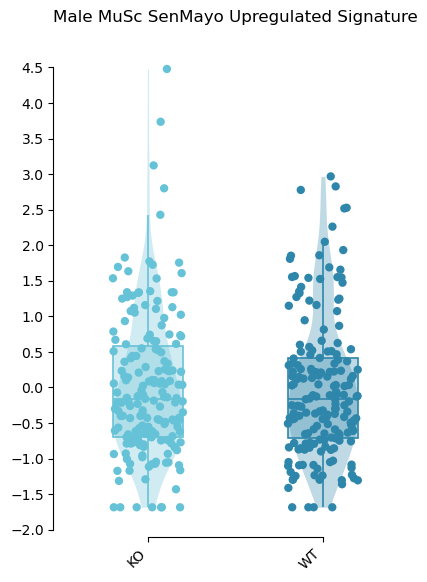

<Figure size 640x480 with 0 Axes>

In [68]:
custom_colors = {
    'KO': '#66C2D7',      # Soft teal blue '#C4A0E7',# Light lavender
    'WT': '#2E86AB',   # Deeper teal blue '#4B0082'    # Indigo
}

fig = plot_violin_box_combo(
    data=scores,
    x_var='condition',
    y_var='senescence_score',
    title='Male MuSc SenMayo Upregulated Signature',
    x_ticks=scores['condition'].unique(),
    palette=custom_colors,
    rotation=45
)

# Display the plot
from IPython.display import display
display(fig)
# save as pdf 
#fig.savefig('/ocean/projects/cis240075p/asachan/datasets/senescence_datasets/mouse_liver/figures/cellage_scores.pdf', bbox_inches='tight')

/tmp/ipykernel_102671/2817451171.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xpos_to_samples = plot_df.groupby('x_position')[sample_col].unique().apply(lambda x: '/'.join(sorted(x)))
2025-11-03 00:36:17 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_102671/2817451171.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_position', y=score, data=df_for_plot, ax=ax, palette="tab10", width=box_width, fliersize=2)
2025-11-03 00:36:17 | [INFO] Using categorical units to plot a 

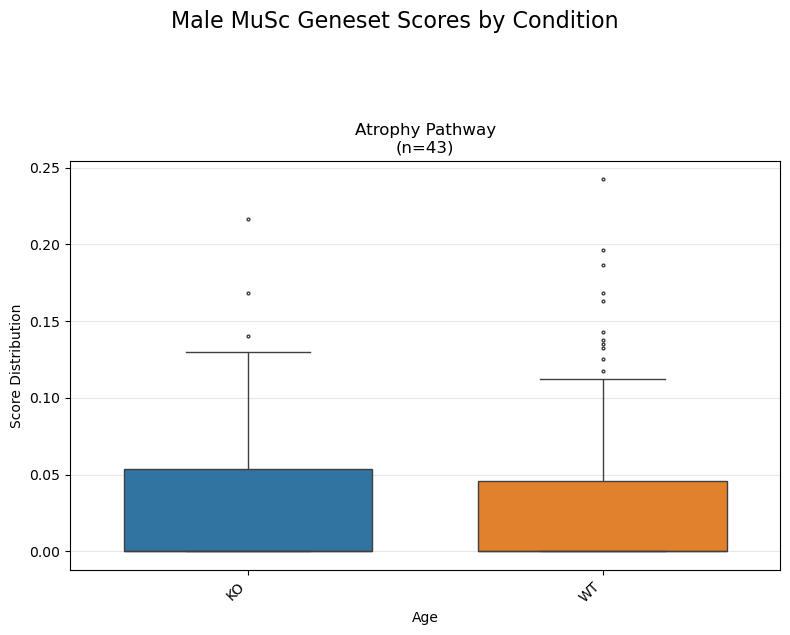

In [39]:
plot_pathway_box_distributions_by_age( # Note the new function name
    df_cell_level=cell_level_scores_df,
    score_cols=score_cols_to_plot,
    geneset_sizes=geneset_sizes_series,
    age_col='condition',
    sample_col='sample_id',
    annotation_col='C_scANVI',
    target_annotation=None,  
    filter_quantile_to_keep_top=None,
    n_subplot_cols=1,
    box_width=0.7,
    sample_label_y_offset_factor=0.08,
    title_text='Male MuSc Geneset Scores by Condition'
)